<a href="https://colab.research.google.com/github/RahulEluri/Dashboard-JavaScript/blob/main/MobileNet_SVM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set parameters
img_height, img_width = 224, 224
batch_size = 64
num_classes = 18
epochs = 30
patience = 4


# Data Generators with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/validate',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = valid_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 29357 images belonging to 18 classes.
Found 6292 images belonging to 18 classes.
Found 6292 images belonging to 18 classes.


In [ ]:
# Load MobileNet without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.6)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)
# model.summary()

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = '/content/drive/MyDrive/best_model.h5'

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [ ]:
# Train the model with callbacks
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
459/459 [==============================] - ETA: 0s - loss: 1.2861 - accuracy: 0.5741 
Epoch 1: val_loss improved from inf to 0.45103, saving model to /content/drive/MyDrive/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


459/459 [==============================] - 10452s 23s/step - loss: 1.2861 - accuracy: 0.5741 - val_loss: 0.4510 - val_accuracy: 0.8546
Epoch 2/30
459/459 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.7796
Epoch 2: val_loss improved from 0.45103 to 0.31662, saving model to /content/drive/MyDrive/best_model.h5
459/459 [==============================] - 498s 1s/step - loss: 0.6123 - accuracy: 0.7796 - val_loss: 0.3166 - val_accuracy: 0.8930
Epoch 3/30
459/459 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8221
Epoch 3: val_loss improved from 0.31662 to 0.26694, saving model to /content/drive/MyDrive/best_model.h5
459/459 [==============================] - 499s 1s/step - loss: 0.4896 - accuracy: 0.8221 - val_loss: 0.2669 - val_accuracy: 0.9072
Epoch 4/30
459/459 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8529
Epoch 4: val_loss improved from 0.26694 to 0.22024, saving model to /content/drive/MyDrive/best_model.h

In [ ]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
# Fine-tune the model with early stopping and model checkpoint
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
model.load_weights('best_model.h5')

Epoch 1/30
459/459 [==============================] - 517s 1s/step - loss: 0.2342 - accuracy: 0.9232 - val_loss: 0.0777 - val_accuracy: 0.9725
Epoch 2/30
459/459 [==============================] - 510s 1s/step - loss: 0.1501 - accuracy: 0.9478 - val_loss: 0.0585 - val_accuracy: 0.9795
Epoch 3/30
459/459 [==============================] - 515s 1s/step - loss: 0.1236 - accuracy: 0.9564 - val_loss: 0.0503 - val_accuracy: 0.9819
Epoch 4/30
459/459 [==============================] - 514s 1s/step - loss: 0.1028 - accuracy: 0.9647 - val_loss: 0.0444 - val_accuracy: 0.9852
Epoch 5/30
459/459 [==============================] - 516s 1s/step - loss: 0.0928 - accuracy: 0.9690 - val_loss: 0.0384 - val_accuracy: 0.9879
Epoch 6/30
459/459 [==============================] - 510s 1s/step - loss: 0.0908 - accuracy: 0.9685 - val_loss: 0.0369 - val_accuracy: 0.9887
Epoch 7/30
459/459 [==============================] - 506s 1s/step - loss: 0.0769 - accuracy: 0.9737 - val_loss: 0.0334 - val_accuracy: 0.9901

In [ ]:
import numpy as np
import pandas as pd

# Extract features from the trained model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Extract features
def extract_features(generator, num_samples):
    features = np.zeros(shape=(num_samples, 1024))
    labels = np.zeros(shape=(num_samples, num_classes))
    i = 0
    for inputs_batch, labels_batch in generator:
        batch_size_actual = inputs_batch.shape[0]
        features_batch = feature_extractor.predict(inputs_batch)
        features[i * batch_size : i * batch_size + batch_size_actual] = features_batch
        labels[i * batch_size : i * batch_size + batch_size_actual] = labels_batch
        i += 1
        if i * batch_size >= num_samples:
            break
    return features, labels

num_train_samples = len(train_generator.filenames)
num_val_samples = len(validation_generator.filenames)
num_test_samples = len(test_generator.filenames)

train_features, train_labels = extract_features(train_generator, num_train_samples)
val_features, val_labels = extract_features(validation_generator, num_val_samples)
test_features, test_labels = extract_features(test_generator, num_test_samples)

# Convert labels to single integers
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Store the features and labels in CSV files
def save_features_to_csv(features, labels, file_name):
    # Combine features and labels into a single DataFrame
    df = pd.DataFrame(features)
    df['label'] = labels  # Add the labels as the last column

    # Save DataFrame to CSV in the specified path
    df.to_csv(f'/content/drive/MyDrive/{file_name}', index=False)

# Save the extracted features to CSV files
save_features_to_csv(train_features, train_labels, 'train_features.csv')
save_features_to_csv(val_features, val_labels, 'val_features.csv')
save_features_to_csv(test_features, test_labels, 'test_features.csv')

print('Features and labels have been saved to CSV files in /content/drive/MyDrive.')


1/1 [==============================] - 0s 94ms/step


In [ ]:
# Convert labels to single integers
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
# Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, n_jobs=-1)
grid.fit(train_features, train_labels)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=2)

In [ ]:
# Save the best model
best_svm_model = grid.best_estimator_
joblib.dump(best_svm_model, 'best_svm_model.pkl')

# Load the best SVM model
best_svm_model = joblib.load('best_svm_model.pkl')

NameError: name 'grid' is not defined

SVM - Validation Accuracy: 0.9261933413557962, Test Accuracy: 0.9053349378259126


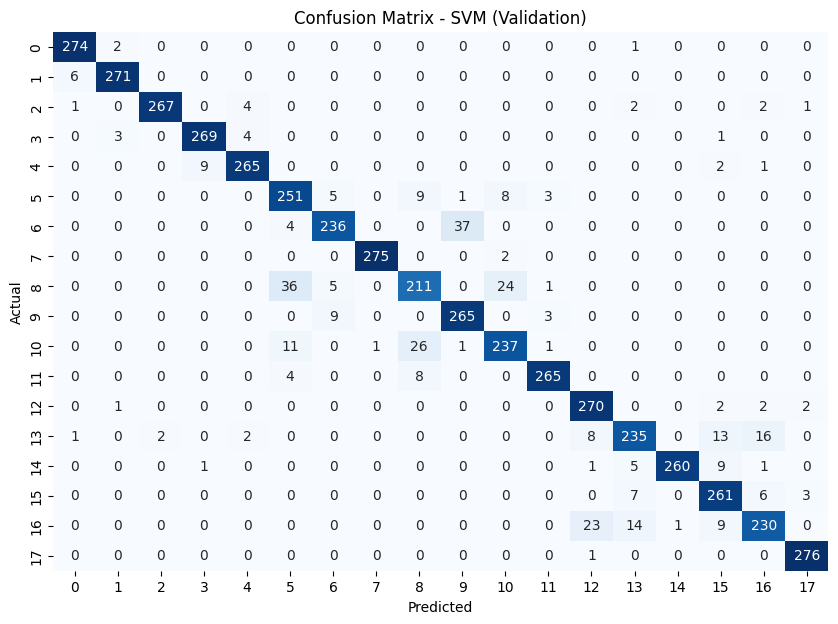

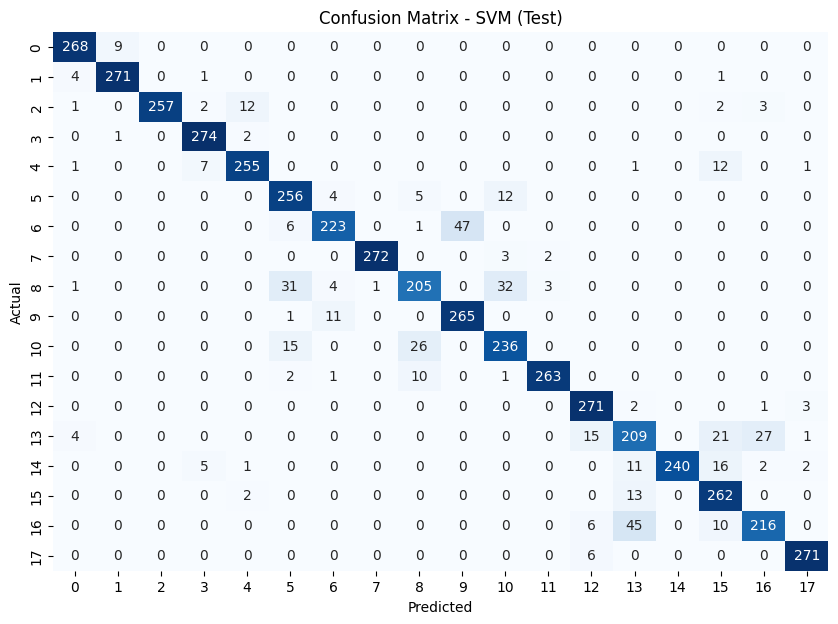

Results saved to svm_model_results.csv


In [ ]:
# Predict and evaluate
train_predictions = best_svm_model.predict(train_features)
val_predictions = best_svm_model.predict(val_features)
test_predictions = best_svm_model.predict(test_features)

train_acc = accuracy_score(train_labels, train_predictions)
val_acc = accuracy_score(val_labels, val_predictions)
test_acc = accuracy_score(test_labels, test_predictions)

train_precision = precision_score(train_labels, train_predictions, average='weighted')
val_precision = precision_score(val_labels, val_predictions, average='weighted')
test_precision = precision_score(test_labels, test_predictions, average='weighted')

train_f1 = f1_score(train_labels, train_predictions, average='weighted')
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')

train_class_report = classification_report(train_labels, train_predictions, output_dict=True)
val_class_report = classification_report(val_labels, val_predictions, output_dict=True)
test_class_report = classification_report(test_labels, test_predictions, output_dict=True)

train_cm = confusion_matrix(train_labels, train_predictions)
val_cm = confusion_matrix(val_labels, val_predictions)
test_cm = confusion_matrix(test_labels, test_predictions)

# Display the evaluation results
print(f'SVM - Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}, Test Accuracy: {test_acc}')


# Plot confusion matrix
def plot_confusion_matrix(cm, model_name, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'{title} - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(train_cm, 'SVM (Training)')
plot_confusion_matrix(val_cm, 'SVM (Validation)')
plot_confusion_matrix(test_cm, 'SVM (Test)')

# Save the results to a DataFrame and CSV
results = [{
    'Model': 'SVM',
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Test Accuracy': test_acc,
    'Training Precision': train_precision,
    'Validation Precision': val_precision,
    'Test Precision': test_precision,
    'Training F1 Score': train_f1,
    'Validation F1 Score': val_f1,
    'Test F1 Score': test_f1,
    'Training Report': train_class_report,
    'Validation Report': val_class_report,
    'Test Report': test_class_report,
    'Training Confusion Matrix': train_cm.tolist(),
    'Validation Confusion Matrix': val_cm.tolist(),
    'Test Confusion Matrix': test_cm.tolist()
}]

df_results = pd.DataFrame(results)
df_results.to_csv('svm_model_results.csv', index=False)
print('Results saved to svm_model_results.csv')

In [ ]:
# Function to predict and return the class label
def predict_image(image_path, model_name='SVM'):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    features = feature_extractor.predict(img_array)
    clf = joblib.load(f'best_svm_model.pkl')
    prediction = clf.predict(features)
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[prediction[0]]

    return predicted_class

# Example usage
image_path = '/content/drive/MyDrive/Datasets/test/Soyabean_Sudden Death Syndrome/Soya_100_3846.jpg'
predicted_class = predict_image(image_path)
print(f'Predicted class by SVM: {predicted_class}')


1/1 [==============================] - 0s 45ms/step
Predicted class by SVM: Soyabean_Sudden Death Syndrome
